# Main Libraries & Functions

## General Functions

In [2]:
import os
import re
import sys
import math

import imageio.v2 as imageio
from PIL import Image
import numpy as np
import cv2 as cv
from scipy.ndimage import zoom

# Plot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from numba import cuda, jit, prange, float32, int32

# Progress bar (for loops)
from tqdm.notebook import tqdm

# Collect time
from timeit import default_timer as timer

In [3]:
def show_subplot(images, titles, gridFormat, figSize=(6, 6), cmap="gray", output_fig_name="output.png", export=False, title=None):
    """This function creates a figure to show subplots automatically"""
    fig = plt.figure(figsize=figSize, dpi=150)

    for idx, image in enumerate(images):
        idx_curr_img = int(str(gridFormat[0]) + str(gridFormat[1]) + str(idx+1))
        plt.subplot(idx_curr_img).set_title(titles[idx], fontsize=8)
        plt.subplot(idx_curr_img).axis('off')
        plt.imshow(image, cmap=cmap)

    if title:
        st = fig.suptitle(title, fontsize=10)
        st.set_y(0.80)

    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

    if export:
        plt.savefig(output_fig_name, dpi=300)

    plt.show()

In [4]:
def load_image_imageio(path_img, resize=None):
    """This function load images using IMAGEIO library"""
    img = imageio.imread(path_img)

    if resize:
        resRows, resCols = resize
        img = Image.fromarray(img).resize((resCols, resRows))

    return np.array(img)

In [5]:
def read_PFM(path_folder, folder, filename, resize=None):
    """Load PFM disparity files from Middlebury Dataset"""
    file = path_folder+folder+"/"+filename
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header == b'PF':
        color = True
    elif header == b'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(rb'^(\d+)\s(\d+)\s$', file.readline())
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)

    # Remove infinite value to display
    disp = data.copy()
    min_disp = np.min(disp[disp != np.inf])
    max_disp = np.max(disp[disp != np.inf])
    if np.inf in disp:
        disp[np.isinf(disp)] = 0

    # Resize & Rescale Disparities
    if resize:
        resRows, resCols = resize
        #Rescale Disparities
        disp_resized = cv.resize(
                            disp,
                            (resCols, resRows),
                            interpolation = cv.INTER_LINEAR,
                        )
        origRows, origCols = disp.shape
        factor = origCols / resCols
        disp_rescaled = disp_resized / factor
        # Update
        disp = disp_rescaled
        min_disp = min_disp / factor
        max_disp = max_disp / factor

    return disp, min_disp, max_disp

def write_pfm(file, array):
    assert type(file) is str and type(array) is np.ndarray and os.path.splitext(file)[1] == ".pfm"
    with open(file, 'wb') as f:
        H, W = array.shape
        headers = ["Pf\n", f"{W} {H}\n", "-1\n"]
        for header in headers:
            f.write(str.encode(header))
        array = np.flip(array, axis=0).astype(np.float32)
        f.write(array.tobytes())

In [6]:
try:
    import wget
except:
    !pip install wget
    import wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f4b101e046cd0555b4b616d8ffbdcaaba1b3757eeb528e1a582ba5d58519fb49
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [7]:
def load_calibration(path_folder, folder):
    """Load calibration file from Middlebury Datasets.
    Documentation (Details): https://vision.middlebury.edu/stereo/data/scenes2014/
    Explanation:
        cam0,1:        camera matrices for the rectified views, in the form [f 0 cx; 0 f cy; 0 0 1], where
        f:             focal length in pixels
        cx, cy:        principal point  (note that cx differs between view 0 and 1)
        doffs:         x-difference of principal points, doffs = cx1 - cx0
        baseline:      camera baseline in mm
        width, height: image size
        ndisp:         a conservative bound on the number of disparity levels;
                       the stereo algorithm MAY utilize this bound and search from d = 0 .. ndisp-1
        isint:         whether the GT disparites only have integer precision (true for the older datasets;
                       in this case submitted floating-point disparities are rounded to ints before evaluating)
        vmin, vmax:    a tight bound on minimum and maximum disparities, used for color visualization;
                       the stereo algorithm MAY NOT utilize this information
        dyavg, dymax:  average and maximum absolute y-disparities, providing an indication of
                       the calibration error present in the imperfect datasets.

    Available in Train, Additional, and Test:
        'cam0', 'cam1', 'doffs', 'baseline', 'width', 'height', 'ndisp'

    Available in Train, Additional:
        'isint', 'vmin', 'vmax', 'dyavg', 'dymax'
    """

    # Data Type
    calib_type = {
        'cam0': str,
        'cam1': str,
        'doffs': float,
        'baseline': float,
        'width': int,
        'height': int,
        'ndisp': int,
        'isint': int,
        'vmin': int,
        'vmax': int,
        'dyavg': float,
        'dymax': float
    }

    # Read calib.txt data
    calib = {}

    with open(path_folder+folder+"/"+'calib.txt', 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            var, content = line.split("=")
            calib[var] = calib_type[var](content)

    # Pre-Processing "cam{0,1}"
    # Camera matrices for the rectified views, in the form [f 0 cx; 0 f cy; 0 0 1]
    calib["cam0"] = list(map(float, calib["cam0"][1:-1].replace(";", "").split(" ")))
    calib["cam1"] = list(map(float, calib["cam1"][1:-1].replace(";", "").split(" ")))
    calib["focallength"] = calib["cam0"][0] # Focal Length
    calib["cx"] = calib["cam0"][2] # cx
    calib["cy"] = calib["cam0"][5] # cy

    return calib

In [8]:
def plot_LR_info(imgL, imgR, model, epipolar_line=None):
    if epipolar_line is None:
        epipolar_line = model.rows//2

    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), width_ratios=[1,1,1])

    ax[0].imshow(imgL)
    ax[0].axhline(y = epipolar_line, color = 'y', linestyle = '-')
    ax[0].title.set_text(f'Left Image')
    ax[0].set_ylabel(f'Epipolar Line {[epipolar_line]}', fontsize=14)
    ax[0].yaxis.label.set_color('red')
    ax[0].set_xlabel(f'Resolution = {imgL.shape}', fontsize=10)

    ax[1].imshow(imgR)
    ax[1].axhline(y = epipolar_line, color = 'y', linestyle = '-')
    ax[1].title.set_text(f'Right Image')
    ax[1].set_xlabel(f'Resolution = {imgR.shape}', fontsize=10)

    ax[2].imshow(model.cost_LR[epipolar_line], cmap="gray")
    ax[2].title.set_text(f'Correlation LR')
    ax[2].set_xlabel(f'Resolution = {model.cost_LR[epipolar_line].shape}', fontsize=10)

    plt.show()

def plot_TD_info(imgL, imgR, model, epipolar_line=None):
    if epipolar_line is None:
        epipolar_line = model.rows//2

    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), width_ratios=[1,1,2])

    ax[0].imshow(imgL)
    ax[0].axhline(y = epipolar_line, color = 'y', linestyle = '-')
    ax[0].title.set_text(f'Left Image')
    ax[0].set_ylabel(f'Epipolar Line {[epipolar_line]}', fontsize=14)
    ax[0].yaxis.label.set_color('red')
    ax[0].set_xlabel(f'Resolution = {imgL.shape}', fontsize=10)

    ax[1].imshow(imgR)
    ax[1].axhline(y = epipolar_line, color = 'y', linestyle = '-')
    ax[1].title.set_text(f'Right Image')
    ax[1].set_xlabel(f'Resolution = {imgR.shape}', fontsize=10)

    ax[2].imshow(model.cost_TD[epipolar_line], cmap="gray")
    ax[2].title.set_text(f'Correlation TD')
    ax[2].set_xlabel(f'Resolution = {model.cost_TD[epipolar_line].shape}', fontsize=10)

    plt.show()

In [9]:
def plot_surface_from_image(image):
    """
    Plot a 3D surface from a grayscale image, treating pixel intensity as the Z-values.

    Parameters:
        image (ndarray): 2D array representing the grayscale image (height map).
    """

    # Create a meshgrid for the image coordinates
    Y, X = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

    # Create the Plotly figure
    fig = go.Figure()

    # Add the 3D surface plot
    fig.add_trace(go.Surface(z=image, x=X, y=Y, colorscale='inferno', opacity=1.0, showscale=False))

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode="cube"
        ),
        title="Plot from Grayscale Image",
        margin=dict(l=0, r=0, b=0, t=30)
    )

    # Show the plot
    fig.show()

In [10]:
def occlusion_masks(D_L, D_R, tau=1.0):
    """
    Compute occlusion masks for both left and right views.

    Args:
        D_L: left-to-right disparity map (H, W)
        D_R: right-to-left disparity map (H, W)
        tau: consistency threshold (e.g., 1 pixel)

    Returns:
        mask_L: occlusion mask for the left image (1 = visible, 0 = occluded)
        mask_R: occlusion mask for the right image
    """
    H, W = D_L.shape
    mask_L = np.ones_like(D_L, dtype=np.uint8)
    mask_R = np.ones_like(D_R, dtype=np.uint8)

    for y in range(H):
        for x in range(W):
            # --- left mask ---
            xr = int(round(x - D_L[y, x]))  # corresponding pixel in right image
            if 0 <= xr < W:
                if abs(D_L[y, x] - D_R[y, xr]) > tau:
                    mask_L[y, x] = 0  # inconsistent disparity -> occluded
            else:
                mask_L[y, x] = 0  # outside the image -> occluded

            # --- right mask ---
            xl = int(round(x + D_R[y, x]))  # corresponding pixel in left image
            if 0 <= xl < W:
                if abs(D_R[y, x] - D_L[y, xl]) > tau:
                    mask_R[y, x] = 0  # inconsistent disparity -> occluded
            else:
                mask_R[y, x] = 0  # outside the image -> occluded

    return mask_L, mask_R

## Importing Feature Extraction from RAFT-Stereo

Reference: https://github.com/princeton-vl/RAFT-Stereo

In [1]:
#FEATURE EXTRACTION RAFT STEREO

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, norm_fn='group', stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        num_groups = planes // 8

        if norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            if not (stride == 1 and in_planes == planes):
                self.norm3 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)

        elif norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(planes)
            self.norm2 = nn.BatchNorm2d(planes)
            if not (stride == 1 and in_planes == planes):
                self.norm3 = nn.BatchNorm2d(planes)

        elif norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(planes)
            self.norm2 = nn.InstanceNorm2d(planes)
            if not (stride == 1 and in_planes == planes):
                self.norm3 = nn.InstanceNorm2d(planes)

        elif norm_fn == 'none':
            self.norm1 = nn.Sequential()
            self.norm2 = nn.Sequential()
            if not (stride == 1 and in_planes == planes):
                self.norm3 = nn.Sequential()

        if stride == 1 and in_planes == planes:
            self.downsample = None

        else:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride), self.norm3)

    def forward(self, x):
        y = x
        y = self.conv1(y)
        y = self.norm1(y)
        y = self.relu(y)
        y = self.conv2(y)
        y = self.norm2(y)
        y = self.relu(y)

        if self.downsample is not None:
            x = self.downsample(x)

        return self.relu(x+y)

class BasicEncoder(nn.Module):
    def __init__(self, output_dim=128, norm_fn='batch', dropout=0.0, downsample=3):
        super(BasicEncoder, self).__init__()
        self.norm_fn = norm_fn
        self.downsample = downsample

        if self.norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=8, num_channels=64)

        elif self.norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(64)

        elif self.norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(64)

        elif self.norm_fn == 'none':
            self.norm1 = nn.Sequential()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1 + (downsample > 2), padding=3)
        self.relu1 = nn.ReLU(inplace=True)

        self.in_planes = 64
        self.layer1 = self._make_layer(64,  stride=1)
        self.layer2 = self._make_layer(96, stride=1 + (downsample > 1))
        self.layer3 = self._make_layer(128, stride=1 + (downsample > 0))

        # output convolution
        self.conv2 = nn.Conv2d(128, output_dim, kernel_size=1)

        self.dropout = None
        if dropout > 0:
            self.dropout = nn.Dropout2d(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.InstanceNorm2d, nn.GroupNorm)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def _make_layer(self, dim, stride=1):
        layer1 = ResidualBlock(self.in_planes, dim, self.norm_fn, stride=stride)
        layer2 = ResidualBlock(dim, dim, self.norm_fn, stride=1)
        layers = (layer1, layer2)

        self.in_planes = dim
        return nn.Sequential(*layers)


    def forward(self, x, dual_inp=False):
        # if input is list, combine batch dimension
        is_list = isinstance(x, tuple) or isinstance(x, list)
        if is_list:
            batch_dim = x[0].shape[0]
            x = torch.cat(x, dim=0)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.conv2(x)

        if self.training and self.dropout is not None:
            x = self.dropout(x)

        if is_list:
            x = x.split(split_size=batch_dim, dim=0)

        return x

class InputPadder:
    """ Pads images such that dimensions are divisible by 8 """
    def __init__(self, dims, mode='sintel', divis_by=8):
        self.ht, self.wd = dims[-2:]
        pad_ht = (((self.ht // divis_by) + 1) * divis_by - self.ht) % divis_by
        pad_wd = (((self.wd // divis_by) + 1) * divis_by - self.wd) % divis_by
        if mode == 'sintel':
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, pad_ht//2, pad_ht - pad_ht//2]
        else:
            self._pad = [pad_wd//2, pad_wd - pad_wd//2, 0, pad_ht]

    def pad(self, *inputs):
        assert all((x.ndim == 4) for x in inputs)
        return [F.pad(x, self._pad, mode='replicate') for x in inputs]

    def unpad(self, x):
        assert x.ndim == 4
        ht, wd = x.shape[-2:]
        c = [self._pad[2], ht-self._pad[3], self._pad[0], wd-self._pad[1]]
        return x[..., c[0]:c[1], c[2]:c[3]]

## Importing Cyclopean-Stereo

In [11]:
import cupy as cp
import numpy as np

def get_TD(cost_LR_np, D_max):
    cost_LR = cp.asarray(cost_LR_np, dtype=cp.float32)
    m, n = cost_LR.shape
    m = m // 2

    # Initialization
    rot = cp.full((m, n), cp.inf, dtype=cp.float32)

    # Obtain vertical_max
    vertical_max = cp.array([min(d, D_max) if d <= n else min(n - d, D_max) for d in range(n)], dtype=cp.int32)

    # Kernel CUDA
    kernel_code = r'''
    extern "C" __global__
    void get_TD_kernel(const float* cost_LR, float* rot, const int* vertical_max, int n, int m) {
        int D = blockIdx.x * blockDim.x + threadIdx.x;
        int t = blockIdx.y * blockDim.y + threadIdx.y;

        if (t < n && D < vertical_max[t] && D < m) {
            int right = t + D;
            int left  = t - D;

            if (0 <= right && right < n && 0 <= left && left < n) {
                rot[D * n + t] = cost_LR[right * n + left];
            }
        }
    }
    '''

    # Compiling kernel
    get_TD_kernel = cp.RawKernel(kernel_code, 'get_TD_kernel')

    threads = (32, 32)
    blocks = (int(np.ceil(m / threads[0])), int(np.ceil(n / threads[1])))

    # Calling kernel
    get_TD_kernel(
        blocks, threads,
        (
            cost_LR.ravel(),
            rot.ravel(),
            vertical_max,
            np.int32(n),
            np.int32(m),
        )
    )

    return cp.asnumpy(rot)

In [12]:
class CyclopeanStereo:
    def __init__(self, path_model):
        # Initialize model's variables
        self.path_model = path_model
        self.rows = None
        self.cols = None

        # Initialize Raft-Stereo variables
        self.embeddings_L = None
        self.embeddings_R = None
        self.feature_dimensionality = None
        self.fnet = None

        # Other important information
        self.cost_LR = None    # Cost Matrix in LR
        self.cost_TD = None    # Cost Matrix in TD

    def initialize_raft_stereo_model(self):
        #Obtaining Full Pretrained model + Filtering only FNET
        #Reference: https://discuss.pytorch.org/t/extract-weights-of-specific-module-from-pretrained-model-file/136228/2
        raft_model = torch.load(self.path_model)
        fnet_state_dict = {}
        for name, weight in raft_model.items():
            if 'fnet' in name:
                fnet_state_dict[name[12:]] = weight

        self.fnet = BasicEncoder(output_dim=256, norm_fn='instance', downsample=2)
        self.fnet.load_state_dict(fnet_state_dict) # Sherlon: Load Pretrained Weights (FNET)

        DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Before: "cpu"
        self.fnet = nn.DataParallel(self.fnet)  # This enables multi-GPU if available
        self.fnet.to(DEVICE)
        self.fnet.eval()

    def feature_extraction(self, left_image, right_image):
        image1 = torch.from_numpy(left_image).permute(2, 0, 1).float()[None]
        image2 = torch.from_numpy(right_image).permute(2, 0, 1).float()[None]
        padder = InputPadder(image1.shape, divis_by=32)
        image1, image2 = padder.pad(image1, image2)

        #Convert to [-1, 1] range
        image1 = (2 * (image1 / 255.0) - 1.0)
        image2 = (2 * (image2 / 255.0) - 1.0)

        # Obtaining Features
        with torch.no_grad():
            embeddings_L, embeddings_R = self.fnet([image1, image2])

        print(f"Before Scaling:", embeddings_L.shape)
        # Upscaling Features
        self.embeddings_L = embeddings_L.squeeze(0).permute(1, 2, 0).cpu().numpy()
        self.embeddings_R = embeddings_R.squeeze(0).permute(1, 2, 0).cpu().numpy()

        # Initialize Edges Mask
        edges_mask_L = None
        edges_mask_R = None

        # Calculate the zoom factors
        factor_rows = 1 * 4
        factor_cols = 2 * 4
        zoom_factors = (factor_rows, factor_cols, 1)  # Scale by "factor" for H and W
        self.embeddings_L = zoom(self.embeddings_L, zoom_factors, mode="nearest", order=1) # Bilinear Interpolation
        self.embeddings_R = zoom(self.embeddings_R, zoom_factors, mode="nearest", order=1) # Bilinear Interpolation

        print(f"After Scaling (H{factor_rows}x, W{factor_cols}x):", self.embeddings_L.shape)

        self.feature_dimensionality = 256

        # Get the number of rows and columns in the image (Both images must have the same size)
        self.rows = self.embeddings_L.shape[0] # Considering Raft Stereo Downsampling
        self.cols = self.embeddings_L.shape[1] # Considering Raft Stereo Downsampling

        return edges_mask_L, edges_mask_R

    def feature_correlation(self):
        self.cost_LR = np.zeros([self.rows, self.cols, self.cols]).astype(np.float32) #Cost Matrix in LR

        #Get the signals (row by row)
        for epipolar_line in range(self.rows):
            signal_a = self.embeddings_L[epipolar_line, :, :]
            signal_b = self.embeddings_R[epipolar_line, :, :]

            #Get the cost matrix between signals A and B
            self.cost_LR[epipolar_line] = self.get_matmul_distances(signal_a, signal_b)

    def get_matmul_distances(self, signal_a, signal_b):
        corr = np.matmul(signal_a, signal_b.T)
        curr_max = np.max(corr)
        curr_min = np.min(corr)
        dist = (curr_max - corr) / (curr_max - curr_min)
        return dist

    def transform_correlation_LR_to_TD(self, D_max):
        self.cost_TD = np.zeros([demo.rows, demo.cols//2, demo.cols]).astype(np.float32) #Cost Matrix in TD

        #Get the signals (row by row)
        for epipolar_line in tqdm(prange(self.rows)):
            self.cost_TD[epipolar_line] = get_TD(self.cost_LR[epipolar_line], D_max=D_max) #Cost Matrix in TD

        # Update Width
        self.cols = self.cols//2

# GET AND PROCESS INPUT DATA

In [13]:
#Set parameters
path_folder = "/content/"
folder = ""

path_imgL = "im0.png"
path_imgR = "im1.png"
path_gt_L = "disp0.pfm"
path_gt_R = "disp1.pfm"
path_calib = "calib.txt"

resolution = "quarter" # "full", "half", "quarter"

In [14]:
# Obs.: You can choose images from Middlebury Dataset by replacing the url below
# DATASET: https://vision.middlebury.edu/stereo/data/scenes2014/datasets/
url = 'https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Flowers-perfect/'

path_files = [path_imgL, path_imgR, path_gt_L, path_gt_R, path_calib]

for curr_file in path_files:
    if os.path.isfile(path_folder+curr_file):
        os.remove(curr_file)
    wget.download(url+curr_file)

In [15]:
# Load Calibration Info
load_calib = load_calibration(path_folder, folder)
print(f"Calibration Info: {load_calib}")

Calibration Info: {'cam0': [4396.869, 0.0, 1353.072, 0.0, 4396.869, 989.702, 0.0, 0.0, 1.0], 'cam1': [4396.869, 0.0, 1538.86, 0.0, 4396.869, 989.702, 0.0, 0.0, 1.0], 'doffs': 185.788, 'baseline': 144.049, 'width': 2880, 'height': 1980, 'ndisp': 640, 'isint': 0, 'vmin': 17, 'vmax': 619, 'dyavg': 0.0, 'dymax': 0.0, 'focallength': 4396.869, 'cx': 1353.072, 'cy': 989.702}


In [16]:
# Set Calibration Parameters
baseline = load_calib["baseline"] # mm
print(f"Baseline: {baseline}")

focal_length = load_calib["focallength"] # px
print(f"Focal Length: {focal_length}")

cx = load_calib["cx"] # px
print(f"Cx: {cx}")

cy = load_calib["cy"] # px
print(f"Cy: {cy}")

Baseline: 144.049
Focal Length: 4396.869
Cx: 1353.072
Cy: 989.702


In [17]:
# Images Resolution
fullRows = load_calib["height"]
fullCols = load_calib["width"]
print(f"Full Resolution: {fullRows} x {fullCols}")

fullndisp = load_calib["ndisp"]
print(f"Number of Disparities: {fullndisp}")

Full Resolution: 1980 x 2880
Number of Disparities: 640


In [18]:
# MODELS: https://www.dropbox.com/s/ftveifyqcomiwaq/models.zip
if not os.path.isfile("models.zip"):
    !gdown "10oq6Rb27_NhBB8dR1GfzqCWPVOh7HPrR"
    !unzip models.zip

path_model = "/content/models/raftstereo-middlebury.pth"

Downloading...
From (original): https://drive.google.com/uc?id=10oq6Rb27_NhBB8dR1GfzqCWPVOh7HPrR
From (redirected): https://drive.google.com/uc?id=10oq6Rb27_NhBB8dR1GfzqCWPVOh7HPrR&confirm=t&uuid=344e3936-0318-471b-9f77-9b43ee5ae3f8
To: /content/models.zip
100% 203M/203M [00:03<00:00, 52.3MB/s]
Archive:  models.zip
   creating: models/
  inflating: models/.DS_Store        
  inflating: models/raftstereo-middlebury.pth  
  inflating: models/iraftstereo_rvc.pth  
  inflating: models/raftstereo-realtime.pth  
  inflating: models/raftstereo-eth3d.pth  
  inflating: models/raftstereo-sceneflow.pth  
  inflating: raft_stereo_512_result.npy  


In [19]:
options = {"full": 1, "half": 2, "quarter": 4}
factor_div = 32 # Raft-Stereo Features
rows_div = round(fullRows/options[resolution]/factor_div)*factor_div
cols_div = round(fullCols/options[resolution]/factor_div)*factor_div
new_size = (rows_div, cols_div)

#########################################################
""" IMPORTANT - ATENTION - IMPORTANT"""                 #
# Manually (Remove This to test on other resolutions)   #
# new_size = (256, 256) # Must be divisible by 32       #
""" IMPORTANT - ATENTION - IMPORTANT"""                 #
#########################################################

height, width = new_size
print(f"{resolution.capitalize()} Resolution: {height} x {width}")
print(f"RAFT-Stereo Features 1/4 Resolution: {height//4} x {width//4}")

Quarter Resolution: 480 x 704
RAFT-Stereo Features 1/4 Resolution: 120 x 176


Min: 7.579385757446289 | Max: 147.80650329589844


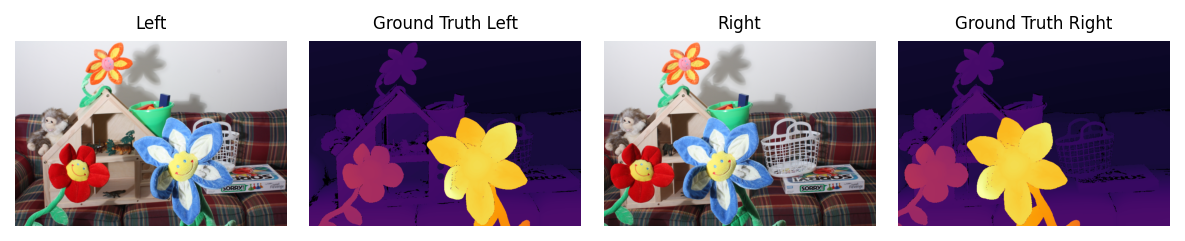

In [20]:
#Load Images
imgL = load_image_imageio(path_imgL, resize=new_size)
imgR = load_image_imageio(path_imgR, resize=new_size)

#Load Ground Truth
gt_L, gt_L_disp_min, gt_L_disp_max = read_PFM(path_folder, folder, path_gt_L, resize = new_size)
gt_R, gt_R_disp_min, gt_R_disp_max = read_PFM(path_folder, folder, path_gt_R, resize = new_size)
print(f"Min: {gt_L_disp_min} | Max: {gt_L_disp_max}")

#Show images side-by-side
show_subplot(images=[imgL, gt_L, imgR, gt_R],
             titles=["Left", "Ground Truth Left", "Right", "Ground Truth Right"],
             gridFormat=(1, 4),
             figSize=(8, 3),
             cmap="inferno")

# Running Cyclopean-Stereo

In [21]:
# Create Model
demo = CyclopeanStereo(path_model)

In [22]:
# Initialize RAFT-Stereo Model
demo.initialize_raft_stereo_model()

In [23]:
# Initialize Parameters
D_max = width
print(f"D_max = {D_max}")

D_max = 704


In [24]:
# Feature Extraction (RAFT-Stereo)
time_start = timer()
demo.feature_extraction(imgL, imgR)
time_end = timer()
print(f"Time to Extract Features: {time_end - time_start:.2f}s")

Before Scaling: torch.Size([1, 256, 120, 176])
After Scaling (H4x, W8x): (480, 1408, 256)
Time to Extract Features: 22.99s


In [25]:
# Feature Correlation (in LR domain)
demo.feature_correlation()

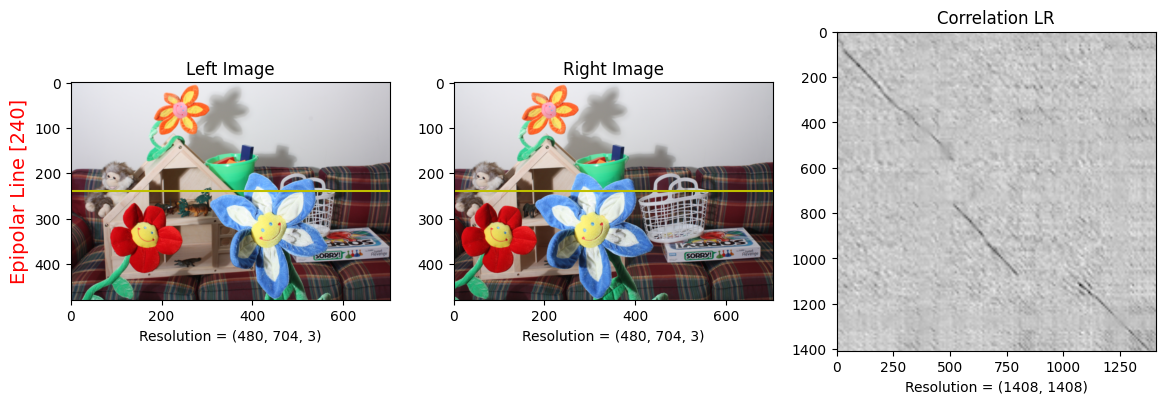

In [26]:
# Choose the epipolar line to plot LR correlation
plot_LR_info(imgL, imgR, demo, epipolar_line=demo.rows//2)

In [27]:
# Feature Correlation (in TD domain)
demo.transform_correlation_LR_to_TD(D_max=D_max)

  0%|          | 0/480 [00:00<?, ?it/s]

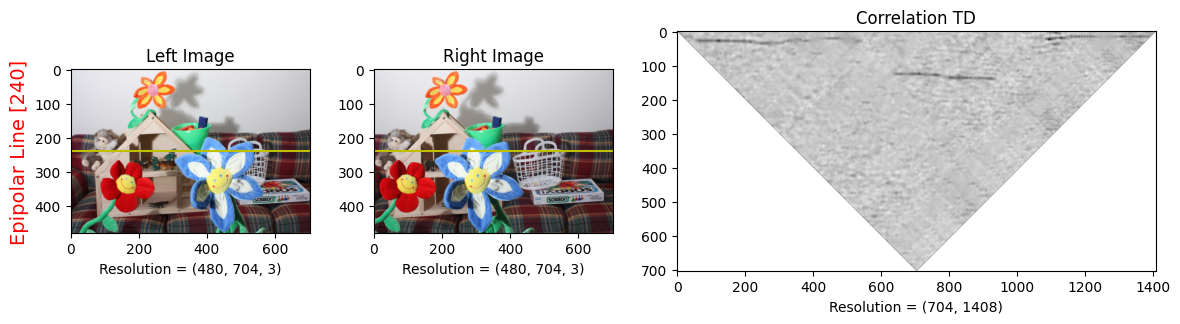

In [28]:
# Choose the epipolar line to plot TD (Cyclopean) correlation
plot_TD_info(imgL, imgR, demo, epipolar_line=demo.rows//2)

# Obtaining Occlusions

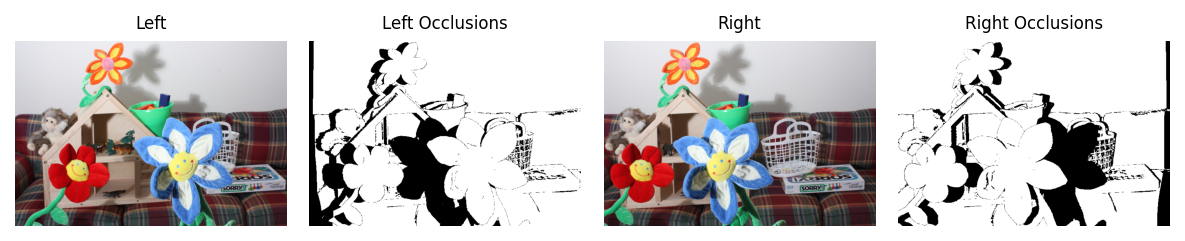

In [29]:
# Obtaining Occlusion Masks
occ_mask_L, occ_mask_R = occlusion_masks(gt_L, gt_R, tau=1.0)

#Show images side-by-side
show_subplot(images=[imgL, occ_mask_L, imgR, occ_mask_R],
             titles=["Left", "Left Occlusions", "Right", "Right Oocclusions"],
             gridFormat=(1, 4),
             figSize=(8, 3))

# Visualization

In [130]:
rows, cols = new_size
data = gt_L.astype(np.uint8).copy() # Choose the Disparities to plot
print(f"Images: {new_size}")
print(f"Cost_LR (1/4, 1/4): {demo.cost_LR.shape}")
print(f"Cost_TD (1/4, 1/4): {demo.cost_TD.shape}")

Images: (480, 704)
Cost_LR (1/4, 1/4): (480, 1408, 1408)
Cost_TD (1/4, 1/4): (480, 704, 1408)


## Interative Analysis (Disparities Segmentation)

Documentation: https://ipywidgets.readthedocs.io/en/7.6.4/examples/Widget%20List.html

In [131]:
def generate_patterned_image(width, height, color=(255, 255, 255), pattern_color=(0, 255, 0), pattern_size=20):
    """
    Generate a white image with a specified pattern.

    Parameters:
    - width (int): Width of the image.
    - height (int): Height of the image.
    - color (tuple): RGB color for the background (default is white).
    - pattern_color (tuple): RGB color for the pattern.
    - pattern_size (int): Thickness of the pattern lines.

    Returns:
    - image (numpy array): The generated image as a NumPy array.
    """
    # Create a white background
    image = np.ones((height, width, 3), dtype=np.uint8)
    image[:] = color  # Set background color

    # Generate patterns
    for offset in range(-height, width, pattern_size * 2):
        # Create the "X" lines
        for y in range(height):
            x1 = y + offset  # Positive slope line
            x2 = width - 1 - y - offset  # Negative slope line
            if 0 <= x1 < width:
                image[y, x1] = pattern_color
            if 0 <= x2 < width:
                image[y, x2] = pattern_color

    return image

In [132]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, Box, interact_manual

depth_min = np.min(data)
depth_max = np.max(data)
ratio = (depth_max-depth_min)/100
middle = (depth_max+depth_min)/2

# Define the slider widget
level_slider = widgets.FloatRangeSlider(
    value=[depth_min, depth_max],
    min=math.floor(depth_min),
    max=math.ceil(depth_max),
    step=ratio,
    description='Disparities: ',
    disabled=False,
    continuous_update=True,
    readout=True,
    orientation='horizontal',
    readout_format='.2f',
    layout=widgets.Layout(width='50%')
)

def plot_disparities(level):
    """ Plot the segmentation using the disparities. """
    disp_min = level[0]
    disp_max = level[1]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), width_ratios=[1,1])

    idx_min = np.where(data < disp_min)
    idx_max = np.where(data > disp_max)
    image = data.copy()
    image[idx_max] = 0
    image[idx_min] = 0
    ax[0].imshow(image, cmap='inferno', interpolation='nearest')
    ax[0].title.set_text(f'Disparities')
    ax[0].set_xlabel(f'D in [{depth_min:.2f}, {depth_max:.2f}] = [{disp_min:.2f}, {disp_max:.2f}]', fontsize=10)
    ax[0].xaxis.label.set_color('red')

    image = imgL.copy()
    texture = False
    # Replacing BG and FG with a Texture
    if texture:
        height, width, _ = imgL.shape
        pattern_background = generate_patterned_image(width, height, color=(0, 0, 0), pattern_color=(0, 255, 0), pattern_size = 20) # Green
        pattern_foreground = generate_patterned_image(width, height, pattern_color=(255, 0, 0), pattern_size = 20) # Blue
        image[idx_max] = pattern_foreground[idx_max]
        image[idx_min] = pattern_background[idx_min]
    else:
        image[idx_max] = 0
        image[idx_min] = 0
    ax[1].imshow(image, cmap='inferno', interpolation='nearest')
    ax[1].title.set_text(f'Left Image')

    plt.show()

# Use interact to link the slider to the plot_model function
interact(plot_disparities, level=level_slider)

interactive(children=(FloatRangeSlider(value=(0.0, 147.0), description='Disparities: ', layout=Layout(width='5…

<function __main__.plot_disparities(level)>

## Interative Analysis (Features)

In [133]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, Box, interact_manual

slice_min = 0
slice_max = rows-1
middle = rows//2
epipolar_line = middle # Global Variable

# Define the slider widget
level_slider = widgets.IntSlider(
    value=middle,
    min=slice_min,
    max=slice_max,
    step=1,
    description='Epipolar Line: ',
    disabled=False,
    continuous_update=False,
    readout=True,
    orientation='horizontal',
    layout=widgets.Layout(width='50%')
)

def plot_slices(level):
    """ Plot image slices."""
    global epipolar_line
    epipolar_line = level

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), width_ratios=[1,1,1])

    # --- Input LR Images ---
    ax[0,0].imshow(imgL)
    ax[0,0].axhline(y = epipolar_line, color = 'r', linestyle = '-')
    ax[0,0].title.set_text(f'Left Image')
    ax[0,0].set_ylabel(f'Epipolar Line {[epipolar_line]}', fontsize=14)
    ax[0,0].yaxis.label.set_color('red')

    ax[1,0].imshow(imgR)
    ax[1,0].axhline(y = epipolar_line, color = 'r', linestyle = '-')
    ax[1,0].title.set_text(f'Right Image')

    # --- Input Occlusion masks ---
    ax[0,1].imshow(occ_mask_L, cmap='gray')
    ax[0,1].axhline(y = epipolar_line, color = 'r', linestyle = '-')
    ax[0,1].title.set_text(f'Left Occlusion Mask')
    ax[0,1].yaxis.label.set_color('red')

    ax[1,1].imshow(occ_mask_R, cmap='gray')
    ax[1,1].axhline(y = epipolar_line, color = 'r', linestyle = '-')
    ax[1,1].title.set_text(f'Right Occlusion Mask')
    ax[1,1].yaxis.label.set_color('red')

    # --- This is what R sees ---
    ax[0,2].imshow(demo.cost_LR[epipolar_line][::2,::2], cmap='gray')
    ax[0,2].plot(np.arange(width), 'k-', )  # Diagonal
    arr_l = np.arange(N)
    arr_r = arr_l + gt_R[epipolar_line]  # pixels correspondentes na direita
    arr_r = np.clip(arr_r, 0, N - 1)
    ax[0,2].plot(arr_l, arr_r, 'go', label='R-Data', markersize=2)
    ax[0,2].title.set_text(f'Cost LR (R Data)')
    ax[0,2].set_xlabel(f"R Point of View")
    ax[0,2].set_ylabel(f"L Occlusion")

    # # --- This is what L sees ---
    ax[1,2].imshow(demo.cost_LR[epipolar_line][::2,::2], cmap='gray')
    ax[1,2].plot(np.arange(width), 'k-', )  # Diagonal
    arr_r = np.arange(N)
    arr_l = arr_r - gt_L[epipolar_line]  # pixels correspondentes na direita
    arr_l = np.clip(arr_l, 0, N - 1)
    ax[1,2].plot(arr_l, arr_r, 'go', label='L-Data', markersize=2)
    ax[1,2].title.set_text(f'Cost LR')
    ax[1,2].set_ylabel(f"L Point of View")
    ax[1,2].set_xlabel(f"R Occlusion")

    # Occlusions
    arr_r = np.where(occ_mask_L[epipolar_line] == 0)[0]
    arr_l = np.zeros_like(arr_r)
    ax[0,2].plot(arr_l, arr_r, 'ro', label='L-Occ', markersize=5)
    ax[0,2].legend()

    arr_l = np.where(occ_mask_R[epipolar_line] == 0)[0]
    arr_r = np.ones_like(arr_l) * (N-1)
    ax[1,2].plot(arr_l, arr_r, 'ro', label='R-Occ', markersize=5)
    ax[1,2].legend()

    # # Show distances in TD
    # ax[4].imshow(demo.cost_TD[epipolar_line], cmap="gray")
    # ax[4].title.set_text(f'Cost_TD')

    fig.tight_layout()
    plt.show()

# Use interact to link the slider to the plot_model function
interact(plot_slices, level=level_slider)

interactive(children=(IntSlider(value=240, continuous_update=False, description='Epipolar Line: ', layout=Layo…

<function __main__.plot_slices(level)>

## Interactive Analysis (Disparity Map Plot)

In [134]:
# Plot Disparity Map
factor = 4 # Downscaling factor
plot_surface_from_image(gt_L[::factor, ::factor])